In [1]:
# %matplotlib inline

### Tutorial Notebook downloaded from: [scikit, pitfalls of coefficients' interpretation.](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py) and currated by Thanasis Argyriou.
### Mind that this tutorial is built on older versions of scikit-learn. Currently, there are better ways to do some things.

Preliminary Definitions:   
[Fit a model](https://en.wikipedia.org/wiki/Goodness_of_fit)  
[Overfitting VS Underfitting](https://en.wikipedia.org/wiki/Overfitting)  
[Bias-Variance tradeoff (underfit VS overfit)](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)   
High Bias => Underfit.  
High Variance = > Overfit

# Common pitfalls in the interpretation of coefficients of linear models

In linear models, the target value is modeled as
a linear combination of the features (see the `linear_model` User Guide
section for a description of a set of linear models available in
scikit-learn).
Coefficients in multiple linear models represent the relationship between the
given feature, $X_i$ and the target, $y$, assuming that all the
other features remain constant (`conditional dependence
<https://en.wikipedia.org/wiki/Conditional_dependence>`_).
This is different from plotting $X_i$ versus $y$ and fitting a
linear relationship: in that case all possible values of the other features are
taken into account in the estimation (marginal dependence).

This example will provide some hints in interpreting coefficient in linear
models, pointing at problems that arise when either the linear model is not
appropriate to describe the dataset, or when features are correlated.

We will use data from the `"Current Population Survey"
<https://www.openml.org/d/534>`_ from 1985 to predict
wage as a function of various features such as experience, age, or education.

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## The dataset: wages

We fetch the data from `OpenML <http://openml.org/>`_.
Note that setting the parameter `as_frame` to True will retrieve the data
as a pandas dataframe.



In [3]:
fetch_openml?

Object `fetch_openml` not found.


In [4]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

In [5]:
# survey.  # uncomment and use tab key to see available attributes

In [6]:
survey.data

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married
...,...,...,...,...,...,...,...,...,...,...
529,18,no,male,5,not_member,29,White,Professional,Other,Unmarried
530,12,no,female,33,not_member,51,Other,Professional,Other,Married
531,17,no,female,25,member,48,Other,Professional,Other,Married
532,12,yes,male,13,member,31,White,Professional,Other,Married


In [7]:
type(survey.data)

pandas.core.frame.DataFrame

In [8]:
survey.target

0       5.10
1       4.95
2       6.67
3       4.00
4       7.50
       ...  
529    11.36
530     6.10
531    23.25
532    19.88
533    15.38
Name: WAGE, Length: 534, dtype: float64

In [9]:
survey.target_names

['WAGE']

Then, we identify features `X` and targets `y`: the column WAGE is our
target variable (i.e., the variable which we want to predict).




In [10]:
X = survey.data[survey.feature_names]

In [11]:
type(X)

pandas.core.frame.DataFrame

In [12]:
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


Note that the dataset contains categorical and numerical variables.
We will need to take this into account when preprocessing the dataset
thereafter.



In [13]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


Our target for prediction: the wage.
Wages are described as floating-point number in dollars per hour.



In [14]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

In [15]:
survey.target.values.ravel?

Docstring:
a.ravel([order])

Return a flattened array.

Refer to `numpy.ravel` for full documentation.

See Also
--------
numpy.ravel : equivalent function

ndarray.flat : a flat iterator on the array.
Type:      builtin_function_or_method

We split the sample into a train and a test dataset.
Only the train dataset will be used in the following exploratory analysis.
This is a way to emulate a real situation where predictions are performed on
an unknown target, and we don't want our analysis and decisions to be biased
by our knowledge of the test data.



In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

First, let's get some insights by looking at the variable distributions and
at the pairwise relationships between them. Only numerical
variables will be used. In the following plot, each dot represents a sample.




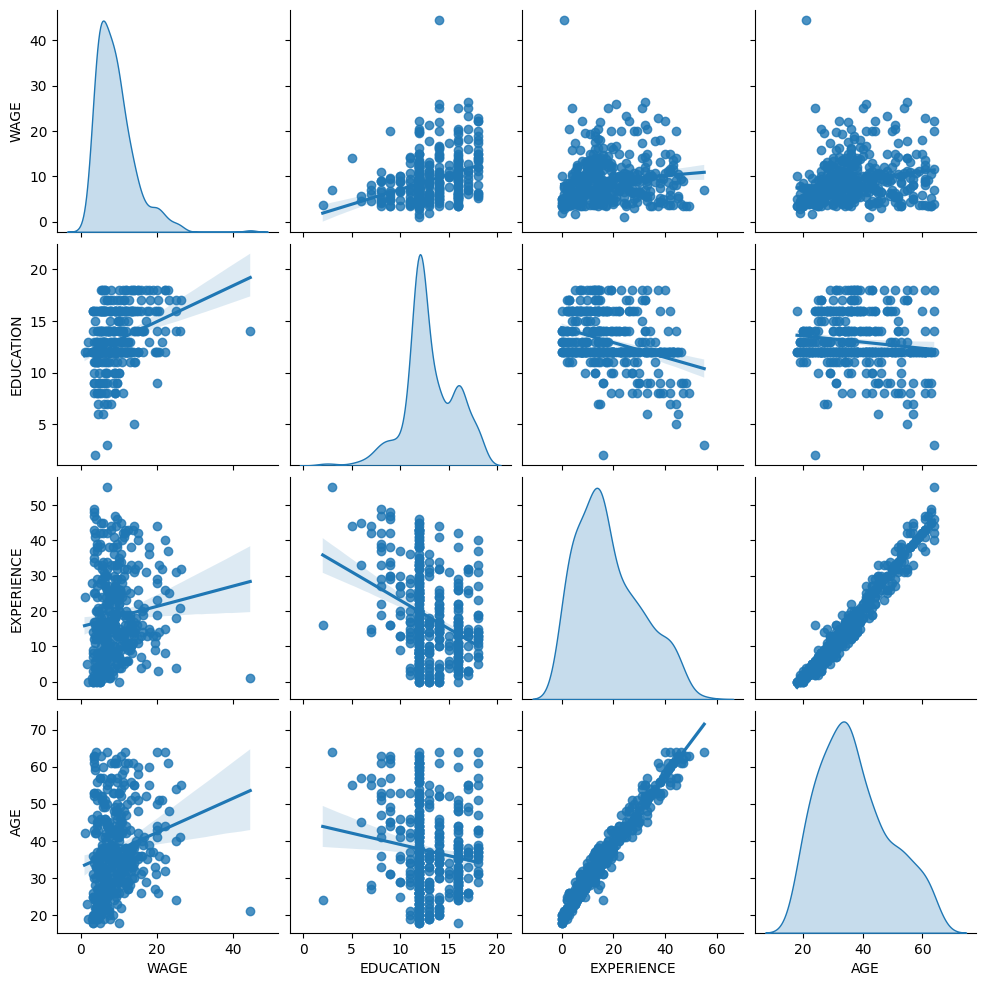

In [17]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")  # kernel density estimation (KDE)

Looking closely at the WAGE distribution reveals that it has a
long tail. For this reason, we should take its logarithm
to turn it approximately into a normal distribution (linear models such
as ridge or lasso work best for a normal distribution of error).

The WAGE is increasing when EDUCATION is increasing.
Note that the dependence between WAGE and EDUCATION
represented here is a marginal dependence, i.e., it describes the behavior
of a specific variable without keeping the others fixed.

Also, the EXPERIENCE and AGE are strongly linearly correlated.


## The machine-learning pipeline

To design our machine-learning pipeline, we first manually
check the type of data that we are dealing with:



In [18]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   AGE         534 non-null    int64   
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), int64(3)
memory usage: 17.3 KB


As seen previously, the dataset contains columns with different data types
and we need to apply a specific preprocessing for each data types.
In particular categorical variables cannot be included in linear model if not
coded as integers first.   

In addition, to avoid categorical features to be
treated as ordered values, we need to one-hot-encode them.  
Our pre-processor will:

- one-hot encode (i.e., generate a column by category) the categorical
  columns;  
- as a first approach we keep numerical values as they are. We will see later how the normalisation of numerical
  values will affect our discussion.

In [19]:
# Here for educational purposes. In production code all imports should be at the top.

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

To describe the dataset as a linear model we use a ridge regressor
with a very small regularization and we will use the logarithm of the WAGE.  
Ridge regressors: Prevent overfitting, higher bias with a lower variance.   
Remember: high variance => overfitting.

When to [use ridge regressors.](https://stats.stackexchange.com/questions/4272/when-to-use-regularization-methods-for-regression)  

Choose the right estimator, [according to scikit](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

In [20]:
# Here for educational purposes. In production code all imports should be at the top.
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

In [21]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

In [22]:
type(model)

sklearn.pipeline.Pipeline

In [23]:
# model?

## Processing the dataset

First, we fit the model.



In [24]:
_ = model.fit(X_train, y_train)

Then we check the performance of the computed model plotting its predictions
on the test set and computing,
for example, the median absolute error of the model.



In [25]:
model.get_feature_names_out?

Signature: model.get_feature_names_out(input_features=None)
Docstring:
Get output feature names for transformation.

Transform input features using the pipeline.

Parameters
----------
input_features : array-like of str or None, default=None
    Input features.

Returns
-------
feature_names_out : ndarray of str objects
    Transformed feature names.
File:      ~/venv_projects/uoa_py_course/course_venv/lib/python3.11/site-packages/sklearn/pipeline.py
Type:      method

In [26]:
# Here for educational purposes. In production code all imports should be at the top.
from sklearn.metrics import median_absolute_error

y_pred = model.predict(X_train)

mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

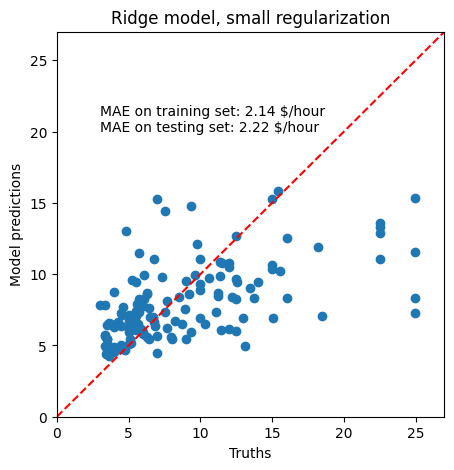

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(3, 20, string_score)
plt.title("Ridge model, small regularization")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

The model learnt is far from being a good model making accurate predictions:
this is obvious when looking at the plot above, where good predictions
should lie on the red line.

In the following section, we will interpret the coefficients of the model.
While we do so, we should keep in mind that any conclusion we draw is
about the model that we build, rather than about the true (real-world)
generative process of the data.

## Interpreting coefficients: scale matters

First of all, we can take a look to the values of the coefficients of the
regressor we have fitted.



In [28]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
RACE_Hispanic,-0.013555
RACE_Other,-0.009111
RACE_White,0.022558
OCCUPATION_Clerical,0.000056
OCCUPATION_Management,0.090538
OCCUPATION_Other,-0.025091
OCCUPATION_Professional,0.071974
OCCUPATION_Sales,-0.046625
OCCUPATION_Service,-0.091042
SECTOR_Construction,-0.000176


The AGE coefficient is expressed in "dollars/hour per living years". while the
EDUCATION one is expressed in "dollars/hour per years of education".   
This representation of the coefficients has the benefit of making clear the
practical predictions of the model: an increase of $1$ year in AGE
means a decrease of $0.030867$ dollars/hour, while an increase of
$1$ year in EDUCATION means an increase of $0.054699$
dollars/hour.   
On the other hand, categorical variables (as UNION or SEX) are
adimensional numbers taking either the value 0 or 1. Their coefficients
are expressed in dollars/hour.   
Then, we cannot compare the magnitude of
different coefficients since the features have different natural scales, and
hence value ranges, because of their different unit of measure. This is more
visible if we plot the coefficients.

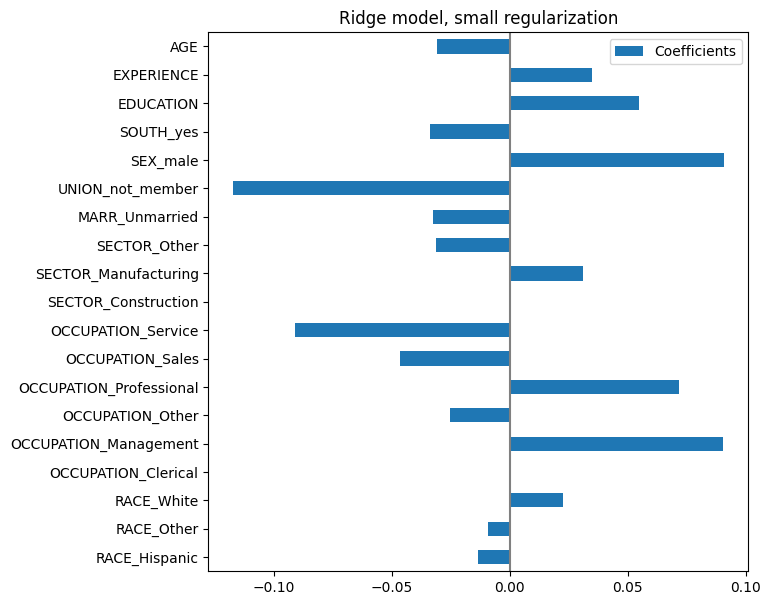

In [29]:
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Looking at the coefficient plot to gauge feature importance can be
misleading as some of them vary on a small scale, while others, like AGE,
varies a lot more, several decades.

This is visible if we compare the standard deviations of different
features.


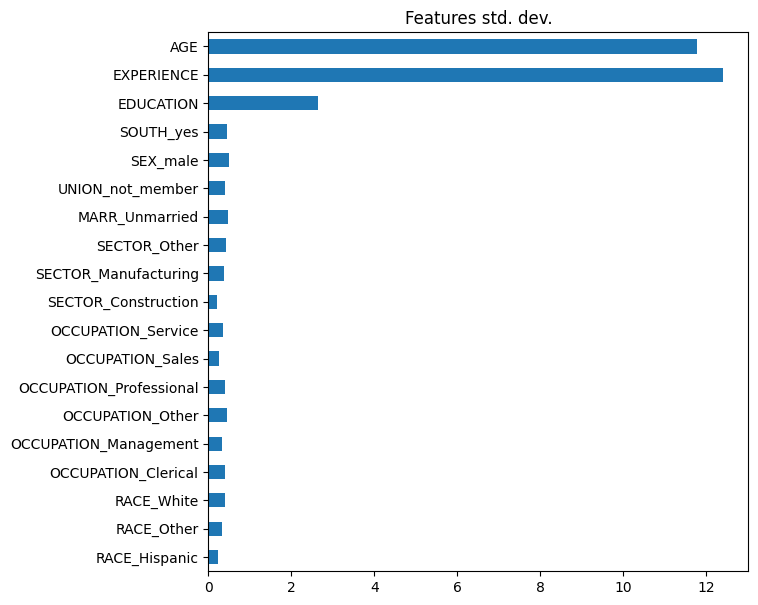

In [30]:
X_train_preprocessed = pd.DataFrame(
    model.named_steps["columntransformer"].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot(kind="barh", figsize=(9, 7))
plt.title("Features std. dev.")
plt.subplots_adjust(left=0.3)

Multiplying the coefficients by the standard deviation of the related
feature would reduce all the coefficients to the same unit of measure.
As we will see `after <scaling_num>` this is equivalent to normalize
numerical variables to their standard deviation,
as $y = \sum{coef_i \times X_i} =
\sum{(coef_i \times std_i) \times (X_i / std_i)}$.

In that way, we emphasize that the
greater the variance of a feature, the larger the weight of the corresponding
coefficient on the output, all else being equal.



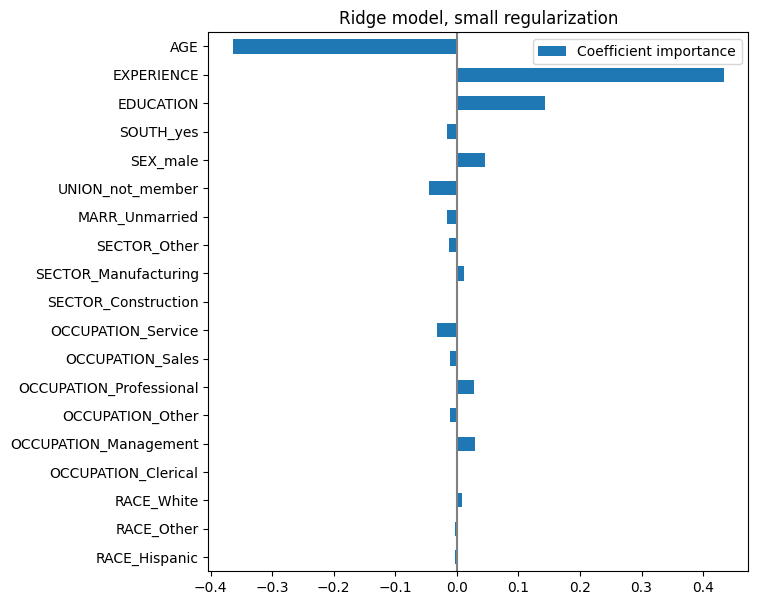

In [31]:
coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_
    * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Now that the coefficients have been scaled, we can safely compare them.

<div class="alert alert-danger"><h4>Warning</h4><p>Why does the plot above suggest that an increase in age leads to a
  decrease in wage? Why the `initial pairplot
  <marginal_dependencies>` is telling the opposite?</p></div>

The plot above tells us about dependencies between a specific feature and
the target when all other features remain constant, i.e., **conditional
dependencies**. An increase of the AGE will induce a decrease
of the WAGE when all other features remain constant. On the contrary, an
increase of the EXPERIENCE will induce an increase of the WAGE when all
other features remain constant.
Also, AGE, EXPERIENCE and EDUCATION are the three variables that most
influence the model.

## Checking the variability of the coefficients

We can check the coefficient variability through cross-validation:
it is a form of data perturbation (related to
`resampling <https://en.wikipedia.org/wiki/Resampling_(statistics)>`_).

If coefficients vary significantly when changing the input dataset
their robustness is not guaranteed, and they should probably be interpreted
with caution.



In [32]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model,
    X,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est.named_steps["transformedtargetregressor"].regressor_.coef_
        * X_train_preprocessed.std(axis=0)
        for est in cv_model["estimator"]
    ],
    columns=feature_names,
)

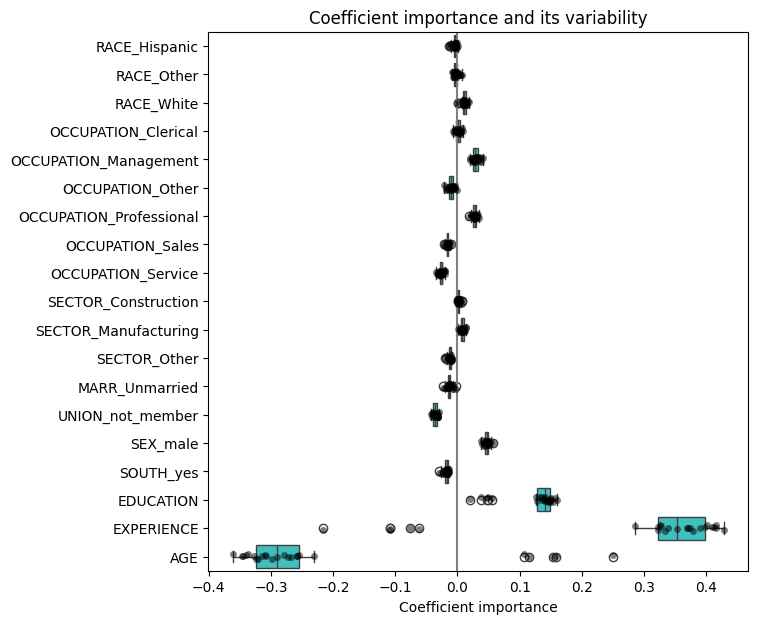

In [33]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

## The problem of correlated variables

The AGE and EXPERIENCE coefficients are affected by strong variability which
might be due to the collinearity between the 2 features: as AGE and
EXPERIENCE vary together in the data, their effect is difficult to tear
apart.

To verify this interpretation we plot the variability of the AGE and
EXPERIENCE coefficient.

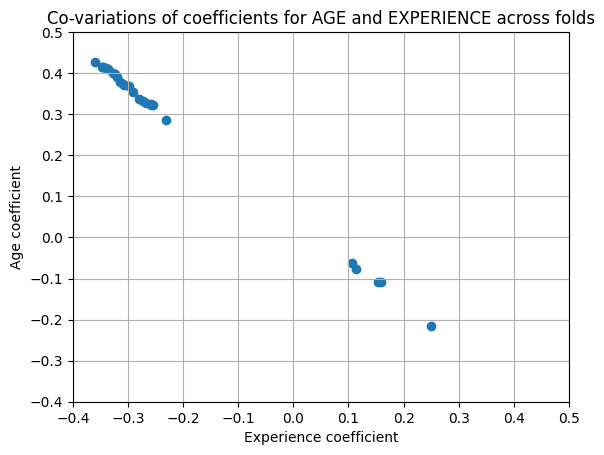

In [34]:
plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

Two regions are populated: when the EXPERIENCE coefficient is
positive the AGE one is negative and vice-versa.

To go further we remove one of the 2 features and check what is the impact
on the model stability.



In [35]:
column_to_drop = ["AGE"]

cv_model = cross_validate(
    model,
    X.drop(columns=column_to_drop),
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est.named_steps["transformedtargetregressor"].regressor_.coef_
        * X_train_preprocessed.drop(columns=column_to_drop).std(axis=0)
        for est in cv_model["estimator"]
    ],
    columns=feature_names[:-1],
)

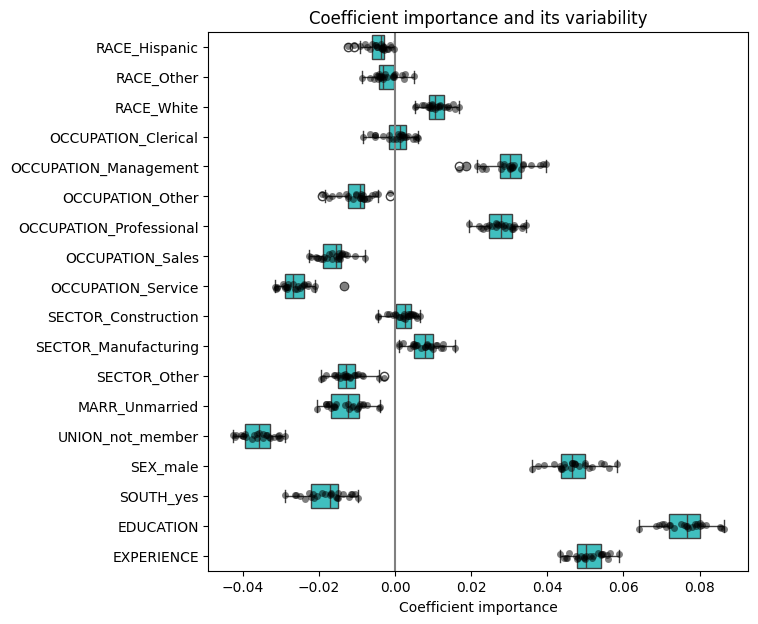

In [36]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.subplots_adjust(left=0.3)

The estimation of the EXPERIENCE coefficient is now less variable and
remain important for all models trained during cross-validation.


## Preprocessing numerical variables

As said above (see "`the-pipeline`"), we could also choose to scale
numerical values before training the model.
This can be useful to apply a similar amount regularization to all of them
in the Ridge.
The preprocessor is redefined in order to subtract the mean and scale
variables to unit variance.



In [37]:
from sklearn.preprocessing import StandardScaler

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder="passthrough",
)

The model will stay unchanged.



In [38]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

_ = model.fit(X_train, y_train)

Again, we check the performance of the computed
model using, for example, the median absolute error of the model and the R
squared coefficient.



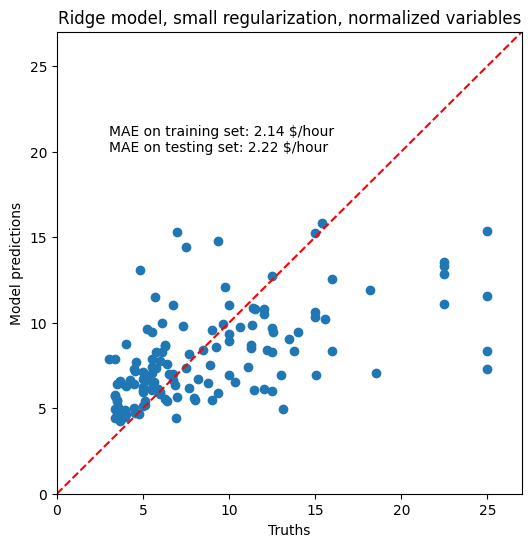

In [39]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title("Ridge model, small regularization, normalized variables")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

For the coefficient analysis, scaling is not needed this time.



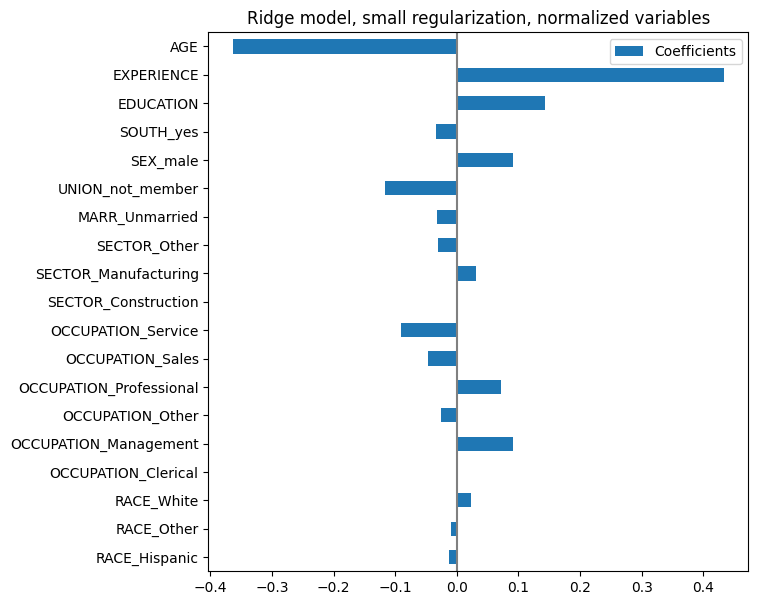

In [40]:
coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

We now inspect the coefficients across several cross-validation folds.



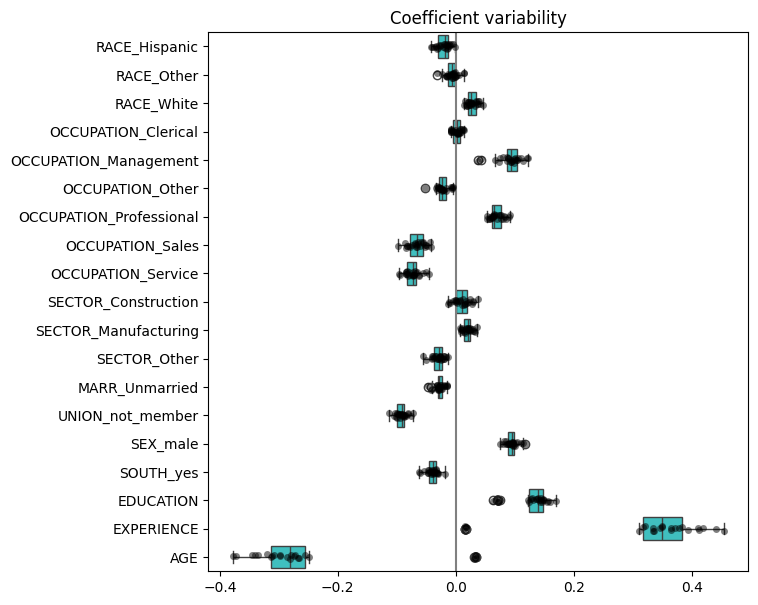

In [41]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [
        est.named_steps["transformedtargetregressor"].regressor_.coef_
        for est in cv_model["estimator"]
    ],
    columns=feature_names,
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

The result is quite similar to the non-normalized case.

## Linear models with regularization

In machine-learning practice, Ridge Regression is more often used with
non-negligible regularization.

Above, we limited this regularization to a very little amount.
Regularization improves the conditioning of the problem and reduces the
variance of the estimates. RidgeCV applies cross validation in order to
determine which value of the regularization parameter (`alpha`) is best
suited for prediction.



In [42]:
from sklearn.linear_model import RidgeCV

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=np.logspace(-10, 10, 21)),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

_ = model.fit(X_train, y_train)

First we check which value of $\alpha$ has been selected.



In [43]:
model[-1].regressor_.alpha_

10.0

Then we check the quality of the predictions.



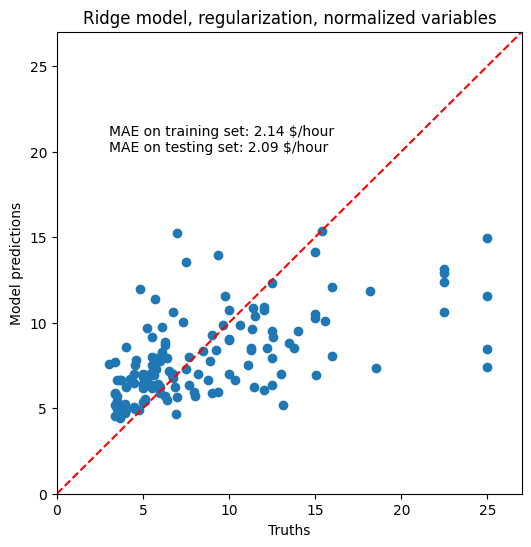

In [44]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title("Ridge model, regularization, normalized variables")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

The ability to reproduce the data of the regularized model is similar to
the one of the non-regularized model.



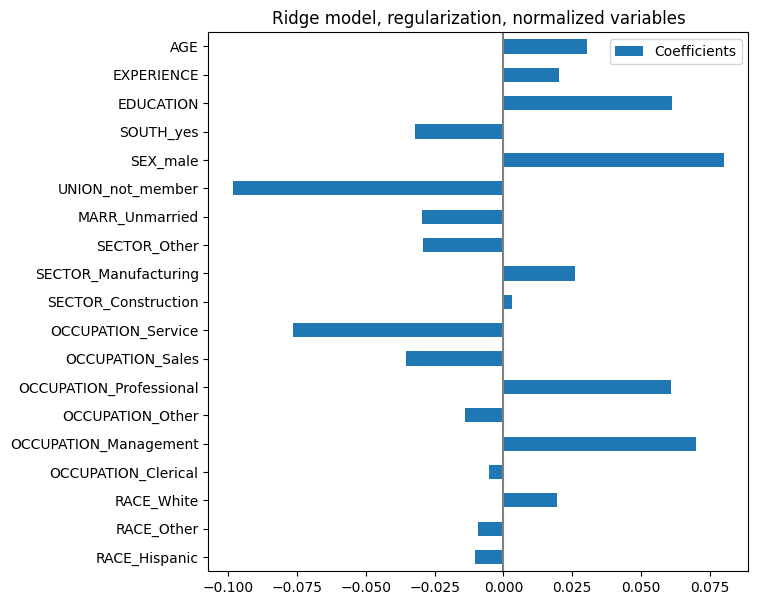

In [45]:
coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model, regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

The coefficients are significantly different.
AGE and EXPERIENCE coefficients are both positive but they now have less
influence on the prediction.

The regularization reduces the influence of correlated
variables on the model because the weight is shared between the two
predictive variables, so neither alone would have strong weights.

On the other hand, the weights obtained with regularization are more
stable  (see the `ridge_regression` User Guide section). This
increased stability is visible from the plot, obtained from data
perturbations, in a cross validation. This plot can  be compared with
the `previous one<covariation>`.



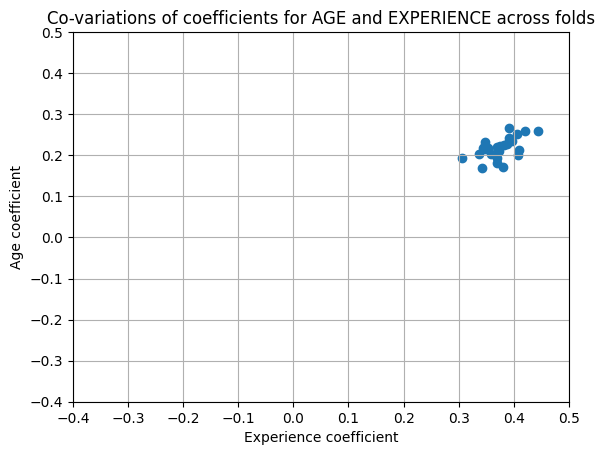

In [46]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [
        est.named_steps["transformedtargetregressor"].regressor_.coef_
        * X_train_preprocessed.std(axis=0)
        for est in cv_model["estimator"]
    ],
    columns=feature_names,
)

plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

## Linear models with sparse coefficients

Another possibility to take into account correlated variables in the dataset,
is to estimate sparse coefficients. In some way we already did it manually
when we dropped the AGE column in a previous Ridge estimation.

Lasso models (see the `lasso` User Guide section) estimates sparse
coefficients. LassoCV applies cross validation in order to
determine which value of the regularization parameter (`alpha`) is best
suited for the model estimation.



In [47]:
from sklearn.linear_model import LassoCV

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=np.logspace(-10, 10, 21), max_iter=100000),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

_ = model.fit(X_train, y_train)

First we verify which value of $\alpha$ has been selected.



In [48]:
model[-1].regressor_.alpha_

0.001

Then we check the quality of the predictions.



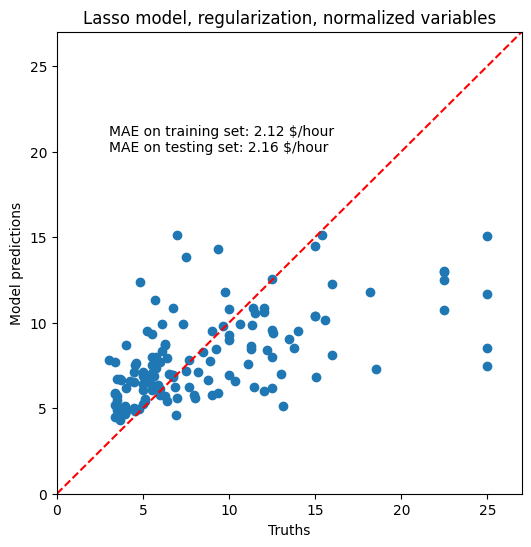

In [49]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title("Lasso model, regularization, normalized variables")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

For our dataset, again the model is not very predictive.



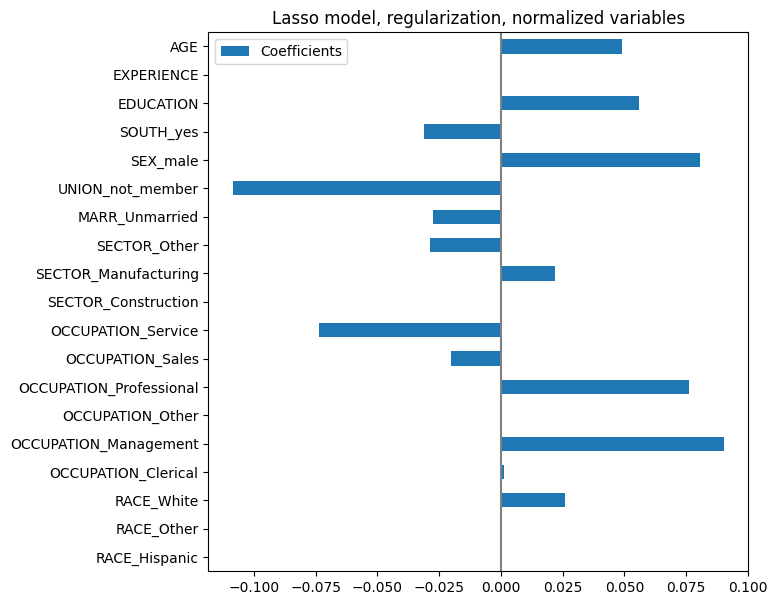

In [50]:
coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model, regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

A Lasso model identifies the correlation between
AGE and EXPERIENCE and suppresses one of them for the sake of the prediction.

It is important to keep in mind that the coefficients that have been
dropped may still be related to the outcome by themselves: the model
chose to suppress them because they bring little or no additional
information on top of the other features.   
Additionally, this selection
is unstable for correlated features, and should be interpreted with
caution.

## Lessons learned

* Coefficients must be scaled to the same unit of measure to retrieve
  feature importance. Scaling them with the standard-deviation of the
  feature is a useful proxy.
* Coefficients in multivariate linear models represent the dependency
  between a given feature and the target, **conditional** on the other
  features.
* Correlated features induce instabilities in the coefficients of linear
  models and their effects cannot be well taken apart.
* Different linear models respond differently to feature correlation and
  coefficients could significantly vary from one another.
* Inspecting coefficients across the folds of a cross-validation loop
  gives an idea of their stability.